# Marker-Controlled Watershed Segmentation

In [1]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math

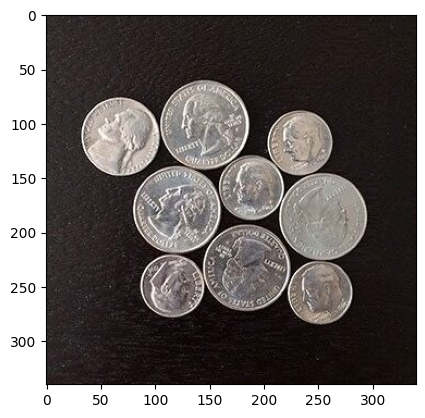

In [2]:
# read image
raw = Image.open("./input_image.jpg")
plt.imshow(raw)

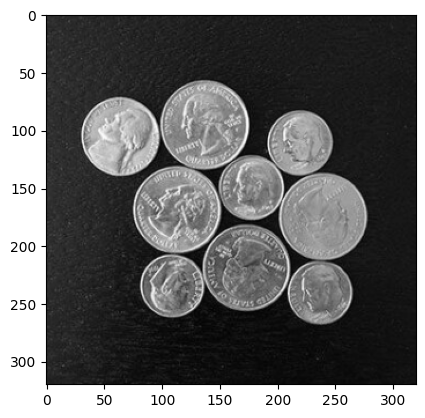

In [3]:
# tensor teansform and convert to grayscale
transform1 = transforms.ToTensor()
transform2 = transforms.Resize((320,320))
rgb_image = transform2(transform1(raw))

gs_img = rgb_image[0] * 0.299 + rgb_image[1] * 0.587 + rgb_image[2] * 0.114
plt.imshow(gs_img, cmap="grey", vmin=0, vmax=1)

## Bilateral Filter

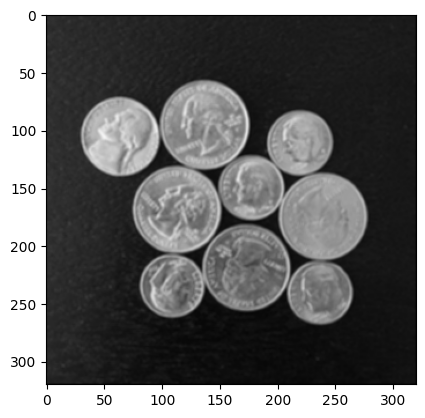

In [4]:
def bilateral_filter(input_image, kernel_size = 3, sigma_spatial = 2, sigma_range = 2):
    # index_prep = useful variable for calculations in order to work with kernel sizes and paddings
    index_prep = kernel_size // 2


    # create padded image
    padded_image = torch.zeros((input_image.shape[0] + kernel_size - 1, input_image.shape[1] + kernel_size - 1))
    # place padded image inside
    padded_image[index_prep:index_prep + input_image.shape[0], index_prep:index_prep + input_image.shape[1]] = input_image


    # create output bilinear image
    bilateral_filtered_image = torch.zeros(input_image.shape)

    # create spatial gaussian
    # create kernel
    kernel = torch.zeros(kernel_size, kernel_size, 2)
    for i in range(kernel_size):
        for j in range(kernel_size):
            kernel[i,j] = torch.tensor([ 0 + j - index_prep  , 0 + i - index_prep ])

    # gaussian function on range
    spatial_gaussian =  torch.exp( - ( kernel[:,:,0] ** 2 + kernel[:,:,1] ** 2) / (2 * sigma_spatial **2)) / (2 * torch.pi * sigma_spatial **2)

    # normalise
    spatial_gaussian = spatial_gaussian / spatial_gaussian.sum()


    for i in range(0, input_image.shape[0]):
        for j in range(0, input_image.shape[1]):

            # extract image
            extracted = padded_image[i:i+kernel_size, j:j+kernel_size]

            pixel_intensity = input_image[i,j]
            # calculate gausian 
            range_gaussian = torch.exp( - ( (extracted - pixel_intensity) ** 2) / (2 * sigma_range **2))  / (2 * torch.pi * sigma_range **2)
                                
            Wp = torch.sum(range_gaussian * spatial_gaussian)
            bilateral_filtering = torch.sum(range_gaussian * spatial_gaussian * extracted) / Wp
            bilateral_filtered_image[i,j] = bilateral_filtering
    
    return bilateral_filtered_image
        

smoothed_image = bilateral_filter(gs_img)
plt.imshow(smoothed_image, cmap='grey', vmin=0, vmax=1)

## Distance Transformation

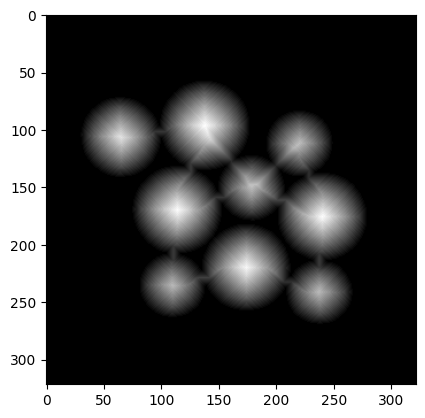

In [5]:
def distance_transformation(input_image, threshold):
    
    # threshold filtering
    input_image = torch.where(input_image > threshold, 1e6, 0)
    
    # create padded image
    padded_image = torch.full((input_image.shape[0] + 2 , input_image.shape[1] + 2), 0)

    # place padded image inside
    padded_image[1:-1, 1:-1] = input_image


    # forward pass (ignoring the padded pixels)
    for i in range(1, padded_image.shape[0] - 1):
        for j in range(1, padded_image.shape[1] - 1):
            padded_image[i,j] = torch.min(torch.tensor(([padded_image[i,j],
                                                                            padded_image[i - 1, j - 1] + math.sqrt(2), 
                                                                            padded_image[i - 1, j] + 1, 
                                                                            padded_image[i, j - 1] + 1, 
                                                                            padded_image[i - 1, j + 1] + math.sqrt(2)])))
    
    # backword pass (ignoring the padded pixels)
    for i in reversed(range(1, padded_image.shape[0] - 1)):
        for j in reversed(range(1, padded_image.shape[1] - 1)):
            padded_image[i,j] = torch.min(torch.tensor(([padded_image[i,j],
                                                        padded_image[i + 1, j - 1] + math.sqrt(2), 
                                                        padded_image[i + 1, j] + 1, 
                                                        padded_image[i, j + 1] + 1, 
                                                        padded_image[i + 1, j + 1] + math.sqrt(2)])))



    return padded_image

# calculate 2 pass Euclidean distance transformation 
distance_image = distance_transformation(smoothed_image, threshold=0.25)
# reverse, because we we have black background
plt.imshow(distance_image, cmap='gray')

## Morphological Reconstruction

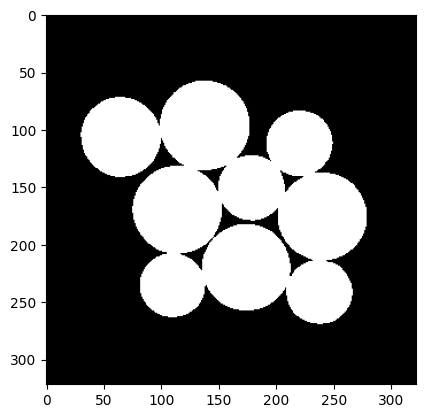

In [6]:

def morthological_reconstruction(input_image):

    # erosion
    M = torch.zeros((input_image.shape))
    for i in range(1, input_image.shape[0] - 1):
        for j in range(1, input_image.shape[1] - 1):
            # if any pixel in 3x3 kernel is 0, then we leave it 0
            # otherwise assign to 1
            if torch.all(input_image[i - 1:i + 2, j - 1:j + 2] != 0):
                M[i, j] = 1

    # dialation
    condition = True

    # if there would not be any more updates, then we finish cycle, otherwise keep updating 
    while condition:
        # clonning current cycle 
        curr_output = M.clone()
        for i in range(1, M.shape[0] - 1):
            for j in range(1, M.shape[1] - 1):
                # clone current kernel
                kernel = M[i - 1:i + 2, j - 1:j + 2].clone()

                # set center pixel to 0
                kernel[1,1] = 0

                # if any of surrounding pixels is 1, and input distance map pixels is not 0, then we fill region with pixel
                if torch.any(kernel == 1) and input_image[i,j] > 0:
                    M[i, j] = input_image[i,j]
        # if filling with 1 is not possible any more, then process id done
        if torch.equal(M, curr_output):
            condition = False
    return M

reconstructed_image = morthological_reconstruction(distance_image)
reconstructed_binary = reconstructed_image.clone()
reconstructed_binary[reconstructed_binary > 0] = 1
plt.imshow(reconstructed_binary, cmap='gray')

## Marked Watershed

### Get Sure Foreground

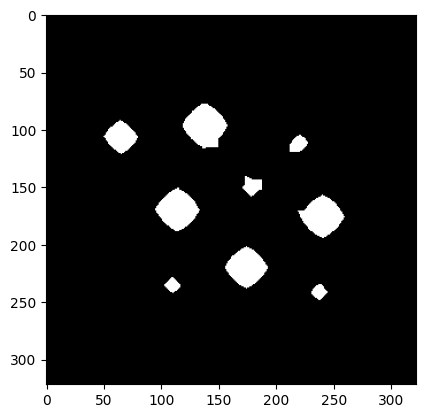

In [7]:
# prune the maxima of distance map to get sure foreground with threshold
sf = reconstructed_image.clone()
sf[sf < 17] = 0
sf[sf > 0] = 1
plt.imshow(sf, cmap='gray')

### Get Sure Background

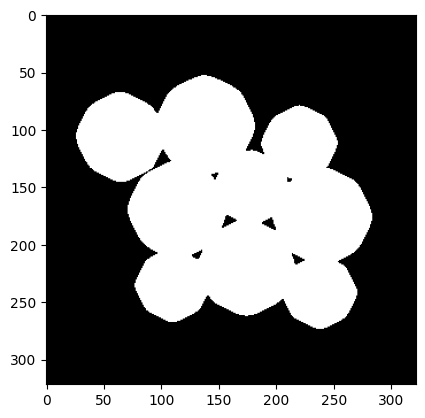

In [8]:
# get confident background with diolation
sb_img = reconstructed_binary.clone()
sb_img_sup = reconstructed_binary.clone()
# repeating 5 times
for _ in range(5):    
    # clonning current cycle 
    for i in range(1, sb_img.shape[0] - 1):
        for j in range(1, sb_img.shape[1] - 1):
            # clone current kernel
            kernel = sb_img[i - 1:i + 2, j - 1:j + 2].clone()

            # set center pixel to 0
            kernel[1,1] = 0

            # if at least 2 pixels in kernel are foreground, then we make it the pixel foreground
            if torch.where(kernel == 1)[0].shape[0] > 2:
                sb_img_sup[i, j] = 1
    # to avoid over diolation, we updating image after whole cycle
    sb_img = sb_img_sup.clone()
plt.imshow(sb_img, cmap='gray')

### Compute gradient with sobel


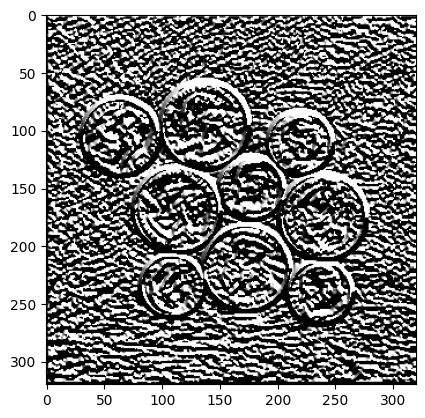

In [9]:

def compute_gradient(input_image):

    # sobel X matris
    x_sobel = torch.tensor([
        [-1, 0 ,1],
        [-2, 0, 2],
        [-1, 0, 1]
    ])

    # sobel Y matrix
    y_sobel = torch.tensor([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2 , 1]
    ])

    # padded image
    padded_image = torch.zeros(input_image.shape[0] + 2, input_image.shape[1] + 2)
    padding = torch.zeros(1)
    for i in range(input_image.shape[0]):
        padded_image[i + 1] = torch.concat((padding, input_image[i], padding))


    # output smoothed image
    output_gradient_magnitue = torch.zeros(input_image.shape[0], input_image.shape[1])
    output_gradient_direction = torch.zeros(input_image.shape[0], input_image.shape[1])

    # update the output image
    for row in range(0,input_image.shape[0]):
        for column in range(0,input_image.shape[1]):
            # Conv operation, but hardcoding for learning process
            # extract required matrix
            extracted_matrix = padded_image[row:row + 3,column:column+3]

            # get sobel multiplication matrixes
            Gx = torch.sum(extracted_matrix * x_sobel)

            Gy = torch.sum(extracted_matrix * y_sobel)

            # update
            output_gradient_magnitue[row][column] = torch.sqrt( Gx **2 + Gy ** 2)
            output_gradient_direction[row][column] = torch.arctan2(Gy, Gx)
        
    return output_gradient_magnitue, output_gradient_direction
gradient_magnitue, gradient_direction = compute_gradient(smoothed_image)
plt.imshow(gradient_direction, cmap='grey', vmin=0, vmax=1)

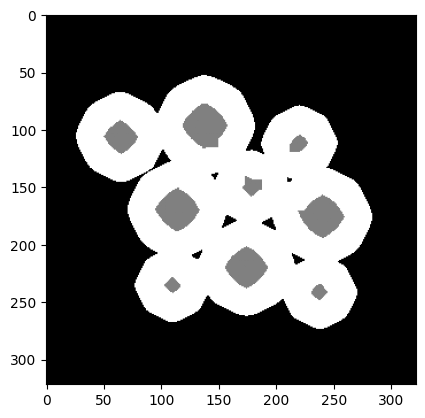

In [12]:

# add background marker
bg_marker = sb_img.clone()
bg_marker[sf.to(torch.bool) ] = 0.5
plt.imshow(bg_marker, cmap='gray')

### Classify markers

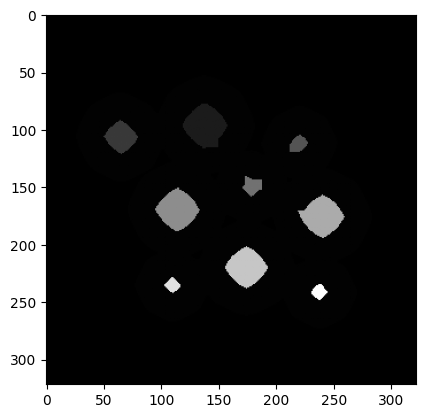

In [11]:
# our classes list, which we would update every time we find new marker
class_list = []
# list of grayscale colours, would use them to assign them to every new class (limited to 20)
grayscale_ints = [int(round(255 * i / 19)) for i in range(20)]

# iterating over image to find new marker
for i in range(1, bg_marker.shape[0] - 1):
    for j in range(1, bg_marker.shape[1] - 1):
        # once we found marker, we would fill it up with class value
        if bg_marker[i,j] == 0.5:

            # get the current marker class value (starting from 1)
            class_val = grayscale_ints[len(class_list) + 1]
            
            # assign current pixel value to marker label
            bg_marker[i,j] = class_val

            # update list with label
            class_list.append(class_val)

            # initial statement to pass while for first time
            statement = True
            while statement:
                # to make sure we would assign current marker pixel, we would change statement to true everytime for loop find marker pixel and adjacent labeled pixel
                statement = False
                for k in range(1, bg_marker.shape[0] - 1):
                    for l in range(1, bg_marker.shape[0] - 1):

                        # look for kernal
                        kernel = bg_marker[k - 1:k + 2, l - 1:l + 2].clone()

                        # flatten it
                        val = kernel.flatten(0,1)

                        #if that pixel is 0.5 (it's marker) and adjacent is labeled, we label pixel with current class value
                        if bg_marker[k,l] == 0.5 and torch.isin(val, class_val).any():
                            bg_marker[k,l] = class_val
                            # force to iterate over image again
                            statement = True

            
plt.imshow(bg_marker, cmap='gray')